<a href="https://colab.research.google.com/github/Djinho/Djinho.github.io/blob/main/Binary_11th_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for binary classification using _ImaGene_

This is a short tutorial to learn the basic usage of _ImaGene_ which contains a series of objects in _python_ to interact with _keras_.

In this example our aim is to predict whether a given locus is under natural selection from population genomic data.
Therefore, we will use _ImaGene_ to perform a binary classification and we will use the classic example of positive selection for lactase persistence in human populations.

The C/T(-13910) variant, or rs4988235, is located on chromosome 2 in the _MCM6_ gene but influences the lactase _LCT_ gene. This SNP is associated with the primary haplotype associated with lactose intolerance in European populations.
In these populations, the common T allele is associated with lactase persistence. Individuals who are homozygous for C allele are likely to be lactose intolerant.
We extracted SNP information from a region of 80k base pairs around the target variant rs4988235 from the 1000 Genomes Project data for all unrelated individuals of CEU population (of European descent).
The data is in the form of a VCF file.

In this tutorial, you will learn how to:
1. read data from VCF file and store it into _ImaGene_ objects,
2. run and process simulations to be used for training,
3. implement, train and evaluate the neural network,
4. deploy the trained network on your genomic data of interest.

In [2]:
#clone the repo
!git clone https://github.com/mfumagalli/ImaGene.git
%cd ImaGene/Tutorials
!pwd


Cloning into 'ImaGene'...
remote: Enumerating objects: 632, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 632 (delta 86), reused 115 (delta 66), pack-reused 497
Receiving objects: 100% (632/632), 139.63 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (397/397), done.
/content/ImaGene/Tutorials
/content/ImaGene/Tutorials


Pip install memory profiler and memory profiler extension

In [3]:
!pip install memory_profiler
%load_ext memory_profiler


Before starting, we need to load the necessary modules in _python_ ...

In [4]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model  # Corrected import
from tensorflow.keras.models import load_model

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pydot  # Optional, but required by TensorFlow Keras to plot the model


... and _ImaGene_.

In [5]:
%run -i ../ImaGene.py

This tutorial has been tested with:
* python 3.9.7
* numpy 1.19.5
* scipy 1.7.1
* keras 2.6.0
* tensorflow 2.6.0
* scikit-image 0.18.3
* scikit-learn 1.0
* matplotlib 3.4.3
* pydot 1.4.2
* pymc3 3.11.4
* ipython 7.28.0
* jupyterlab 3.1.14

### 1. Read data from VCF file and store it into _ImaGene_ objects

We store the information of the genomic data into an _ImaFile_ object where we specify the name of the VCF file and the number of samples (i.e. the number of chromosomal copies, twice the number of individuals for a diploid organism).
The latter parameter is not strictly necessary but it is useful to check whether the VCF we are analysing contains the data that we expect.

In [6]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='LCT.CEU.vcf')

We create an _ImaGene_ object by reading the VCF file and generating a matrix of haplotypes.

In [7]:
gene_LCT = file_LCT.read_VCF()

An _ImaGene_ has a series of useful methods.
For instance, we can have a quick look at the data stored in this object.

In [8]:
gene_LCT.summary();

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 2200, max 2200, mean 2200.000000, std 0.000000


As expected, we have one image with 198 rows (equivalent to the number of sampled chromosomal copies) and 2200 columns representing all genomic positions reported.
It is likely that not all of these positions will be polymorphic in the CEU sample as the VCF file reports variats across all analysed populations.

Similarly, we may want to discard rare variants as they may be more associated to errors or be less informative of the scenario we want to predict.
Assume that we want to ignore monomorphic sites and singletons for the derived allele.
We can accomplish this with the following command.

In [9]:
gene_LCT.filter_freq(0.01);

If we are unsure about the ancestral/derived polarisation of alleles, we can convert them into major/minor alleles using the method `.majorminor()`.
We can have a look at the resulting image.

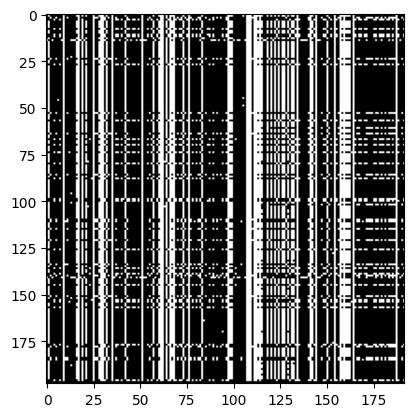

In [10]:
gene_LCT.plot();

As the order on the rows is arbitrary, we can order them (and columns) following several criteria.
We can do this with _ImaGene_ with the `.sort` method which has the following options.

In [ ]:
gene_LCT.sort?

Assume that we wish to sort only rows by their frequency (with the most frequent haplotypes on the top).
This can be done with the following command (which will also visualise the resulting image).

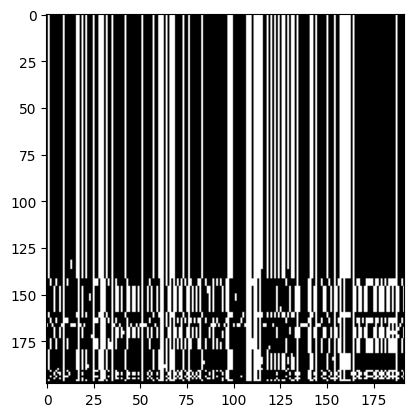

In [11]:
gene_LCT.sort('rows_freq');
gene_LCT.plot();

Once we are happy with our data processing (e.g. filtering and sorting), we need to convert the image into an appropriate format which will be later used for the prediction.
As an illustration, we also flip black and white pixels to assign the former to derived (or minor) alleles which is the standard representation of genomic data.

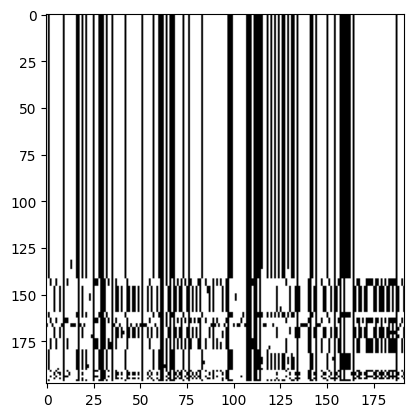

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


In [12]:
gene_LCT.convert(flip=True);
gene_LCT.plot();
gene_LCT.summary();

We finally note that our image has 192 columns now, representing the number of retained SNPs.

We can save our _ImaGene_ object in the working `path` directory.

In [13]:
# set as appropriate, e.g.:
# path='/home/mfumagal/Data/ImaGene/Tutorials/Data/' # my local machine
# path = './' # for workshop spp1819
path = './'

In [14]:
gene_LCT.save(file=path + 'gene_LCT');

As an illustration, the following line will load the _ImaGene_ object.

In [15]:
gene_LCT = load_imagene(file=path + 'gene_LCT');

### 2. Run and process simulations to be used for training the neural network

_ImaGene_ provides users with an easy interface with _msms_ to run simulations which will be used for training the network.
The script `../generate_dataset.sh` accepts an input file which specifies the parameters of the simulations.
A generic file with all descriptions is `../params.txt`.
If you want to make changes, you need to open the parameter file, change the value of the desired options, save and close it.

We provide an example of this file called `params_binary` which simulates a total of 200,000 loci of 80kbp either under neutral evolution or positive selection with additive effect and an allelic selection coefficient of $1.5$\% targeting a variant in the middle of the region.
Selection starts 800 generations ago (corresponding to 20kya with a generation time of 25 years) with an allele frequency of $0.01$.
We impose a mutation rate is $1.5e-8$ per base per generation and a recombination rate of $1e-8$.
Finally, the simulated population follows a 3-epoch model of bottleneck and expansion as proposed by [Marth et al. 2004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1470693/) for a European population.
We sampled 198 chromosomal copies to match our observed data.

After we specify the directories for _msms_ and the folder where all the simulations will be stored, we can run the following command to perform the simulations. This script will split the simulations into different batches to later perform training with a "simulation-on-the-fly" approach.

In [19]:
# if you wish to generate new training data, do not run otherwise
import subprocess
subprocess.call("bash ../generate_dataset.sh params_binary.txt".split());

Let's perform the first iteration of training.
To do that, we need to read the first batch of simulations in `[..]/Binary/Simulations1`and store them into an _ImaFile_ object.

In [20]:
# set as appropriate, e.g.:
# path_sim='/home/mfumagal/Data/ImaGene/Tutorials/' # my local machine
# path_sim='/mnt/quobyte/ImaGene/' # for workshop spp1819
path_sim = './'

In [21]:
file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain.
As a quick example, we will use only 2000 data points per class.

In [24]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000);

We can have a look at the data stored in this object.

In [25]:
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 144, max 482, mean 293.523500, std 66.047411


We have 4000 images in this object. Recall that with the first line we simulated 2 classes and retained 2000 data points for each class. All images have 198 rows as expected, as this represents the number of simulated haplotypes. However, images have different number of columns, ranging from $\approx 130$ to $\approx 450$ with an average value of $\approx 295$. The number of columns represents the number of polymorphic sites and fixed derived alleles in a _msms_ file. This number may vary from simulated gene to another.
Our observed data for LCT has 192 columns.

As mentioned before, _ImaGene_ provides functionalities to manipulate our data. Specifically we can do the following:
* convert ancestral/derived to major/minor allele polarisation
* filter out columns based on a minimum allele frequency (e.g. 0.01)
* sorting rows and columns by frequency (or genetic distance from the most frequent entry)

We need to follow the same data processing as the one employed for the real data.

In [26]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 79, max 392, mean 217.714500, std 54.346021


All images must have the same dimensions. You can explore all different options for resizing.

In [24]:
?gene_sim.resize

One possibility would be to resize them to match the dimensions of the real data.
In this case it means resize all images to have shape (198, 192) which can be achieved with the following command.

In [27]:
gene_sim.resize((198, 192));
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


After the data manipulation is done, we need to convert images to proper _numpy_ float matrices,as previously discussed. The following line will do the job (including flipping black/white pixels).
Note that the `.convert` method allows you to normalise the data too.

In [28]:
gene_sim.convert(flip=True);
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


Note that in addition to the genomic data, an _ImaGene_ object contains information on the corresponding targets (in this case the selection coefficient, either 0 or 300 in $2N_e$ units with $N_e = 10000$).
As an illustration, let's plot one random image per class.

0


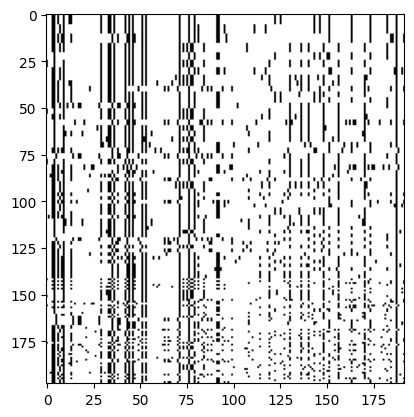

300


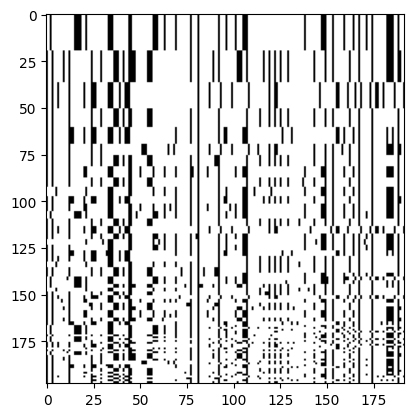

In [34]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

Finally we need to randomly shuffle our images before using them for training our network.
We can easily accomplish this with the following line.

In [35]:
gene_sim.subset(get_index_random(gene_sim));

Our targets represent the 2 possible classes. However, since we are doing a binary classification, we need to vectorise them as required by _keras_.

In [36]:
gene_sim.targets = to_binary(gene_sim.targets);

The object is now ready to be used for the classification!
You can save it.

In [37]:
gene_sim.save(file=path + 'gene_sim.binary')

0

If you want to load an _ImaGene_ object you can use the following function.

In [38]:
gene_sim = load_imagene(file=path + 'gene_sim.binary')

In [39]:
import time
import os
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Add any other imports you don't already have, such as TensorFlow related ones if not present


Import and fucntions to measure epoch time and training time

In [40]:
import time
from tensorflow.keras import models, layers, regularizers, callbacks
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
        self.total_time = time.time()

    def on_epoch_begin(self, batch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.total_time

### 3. Implement, train and evaluate the neural network

Now that our data is ready, we can build our network.
Specifically, we can build a model in _keras_ with convolutional, pooling and dense layers.
In this example we have 3 layers of 2D convolutions and pooling followed by a fully-connected layer.
We just need to specify the dimensions of the data in the first layer, and this is specified by the option `input_shape=gene_sim.data.shape[1:]`.

In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

# Define your model
model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

# Compile your model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

def get_flops(model):
    forward_pass = tf.function(model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
    graph_info = profile(forward_pass.get_concrete_function().graph, options=ProfileOptionBuilder.float_operation())
    flops = graph_info.total_float_ops  # Corrected attribute name
    return flops

# Calculate FLOPs and MACs
flops = get_flops(model)
macs = flops / 2
print(f"MACs: {macs:,} (Multiply-Accumulate Operations)")
print(f"FLOPs: {flops:,} (Floating Point Operations)")




MACs: 136,062,656.5 (Multiply-Accumulate Operations)
FLOPs: 272,125,313 (Floating Point Operations)


Then, let's compile our _keras_ model.

In [48]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Calculate the number of paramters in the model

In [49]:
# Assuming `model` is your compiled model
total_params = model.count_params()
print(f"Total Parameters: {total_params}")


Total Parameters: 4173473


Let's look at a summary of the model and plot it.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 196, 190, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 98, 95, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 96, 93, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 48, 46, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 44, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 23, 22, 64)       

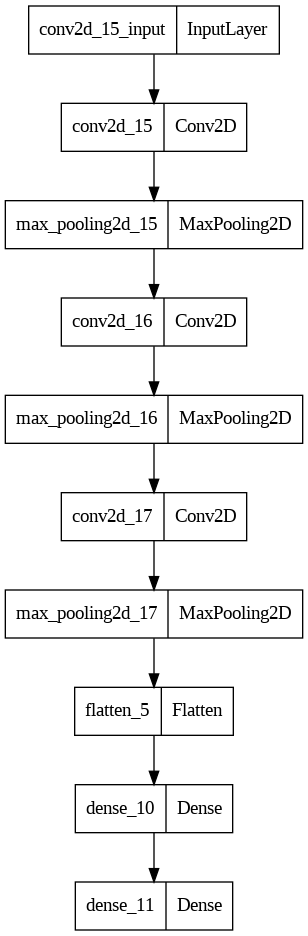

In [50]:
model.summary()
plot_model(model, path + 'net.binary.png')

In [51]:
%%memit
time_callback = TimeHistory()
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10, callbacks=[time_callback])
print(f"Total training time for initial batch: {time_callback.total_time}s")
print(f"Average epoch time for initial batch: {sum(time_callback.times) / len(time_callback.times) if time_callback.times else 0}s")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


29/29 [==============================] - 87s 3s/step - loss: 5.8534 - accuracy: 0.5511 - val_loss: 4.6839 - val_accuracy: 0.4550


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total training time for initial batch: 87.37318706512451s
Average epoch time for initial batch: 87.27683639526367s
peak memory: 2964.54 MiB, increment: 1637.64 MiB


Remember that you can save a _keras_ model with `model.save('net.h5')`.

Now we can initialise a network object _ImaNet_.

In [52]:
net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

We can keep track of scores (loss and accuracy) across iterations with `.update_scores`.

In [53]:
net_LCT.update_scores(score);

Now we need to repeat the whole procedure described above using all remaning batches of data, leaving the last one for testing.

In [54]:
i = 2
while i < 10:
    print(f"Processing batch {i}")

    # Load and preprocess the data for the current batch
    file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    # Initialize TimeHistory for the current training session
    time_callback = TimeHistory()

    # Train the model on the current batch with the TimeHistory callback
    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10, callbacks=[time_callback])

    # Update ImaNet scores with the latest training session's results
    net_LCT.update_scores(score)

    # Reporting time metrics for the current batch
    total_training_time = time_callback.total_time
    average_epoch_time = sum(time_callback.times) / len(time_callback.times) if time_callback.times else 0
    print(f"Total training time for batch {i}: {total_training_time}s")
    print(f"Average epoch time for batch {i}: {average_epoch_time}s")

    i += 1


Processing batch 2
29/29 [==============================] - 82s 3s/step - loss: 3.4795 - accuracy: 0.6378 - val_loss: 2.8307 - val_accuracy: 0.5000
Total training time for batch 2: 82.52133679389954s
Average epoch time for batch 2: 82.49706411361694s
Processing batch 3
29/29 [==============================] - 84s 3s/step - loss: 2.2496 - accuracy: 0.6189 - val_loss: 1.8091 - val_accuracy: 0.5900
Total training time for batch 3: 83.73026418685913s
Average epoch time for batch 3: 83.69232606887817s
Processing batch 4
29/29 [==============================] - 82s 3s/step - loss: 1.6027 - accuracy: 0.7550 - val_loss: 1.3420 - val_accuracy: 0.7200
Total training time for batch 4: 81.6700828075409s
Average epoch time for batch 4: 81.64705181121826s
Processing batch 5
29/29 [==============================] - 82s 3s/step - loss: 1.2222 - accuracy: 0.7961 - val_loss: 1.0071 - val_accuracy: 0.9500
Total training time for batch 5: 81.59914374351501s
Average epoch time for batch 5: 81.5775032043457

We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

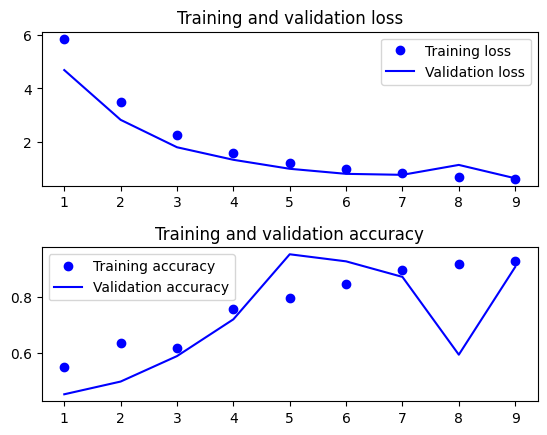

0

In [55]:
net_LCT.plot_train()

We save (and/or load) the final trained model.

In [56]:
model.save(path + 'model.binary.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
model = load_model(path + 'model.binary.h5')

You can also save the network itself (and load it).

In [58]:
net_LCT.save(path + 'net_LCT.binary');

In [59]:
net_LCT = load_imanet(path + 'net_LCT.binary')

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [60]:
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test) # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

Let's report loss and accuracy on the testing set.

In [61]:
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]

[0.7085270285606384, 0.859000027179718]


Calculate and plot the ROC Curve and AUC score for the model on the testing set.

63/63 [==============================] - 34s 527ms/step


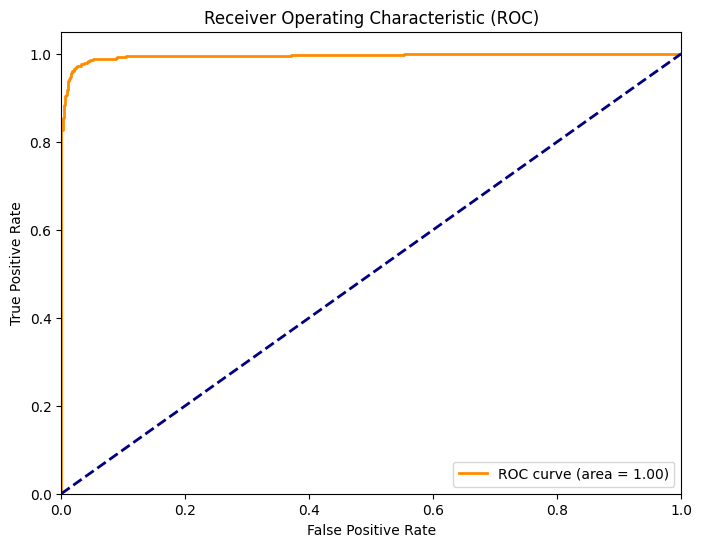

1/1 [==============================] - 0s 60ms/step


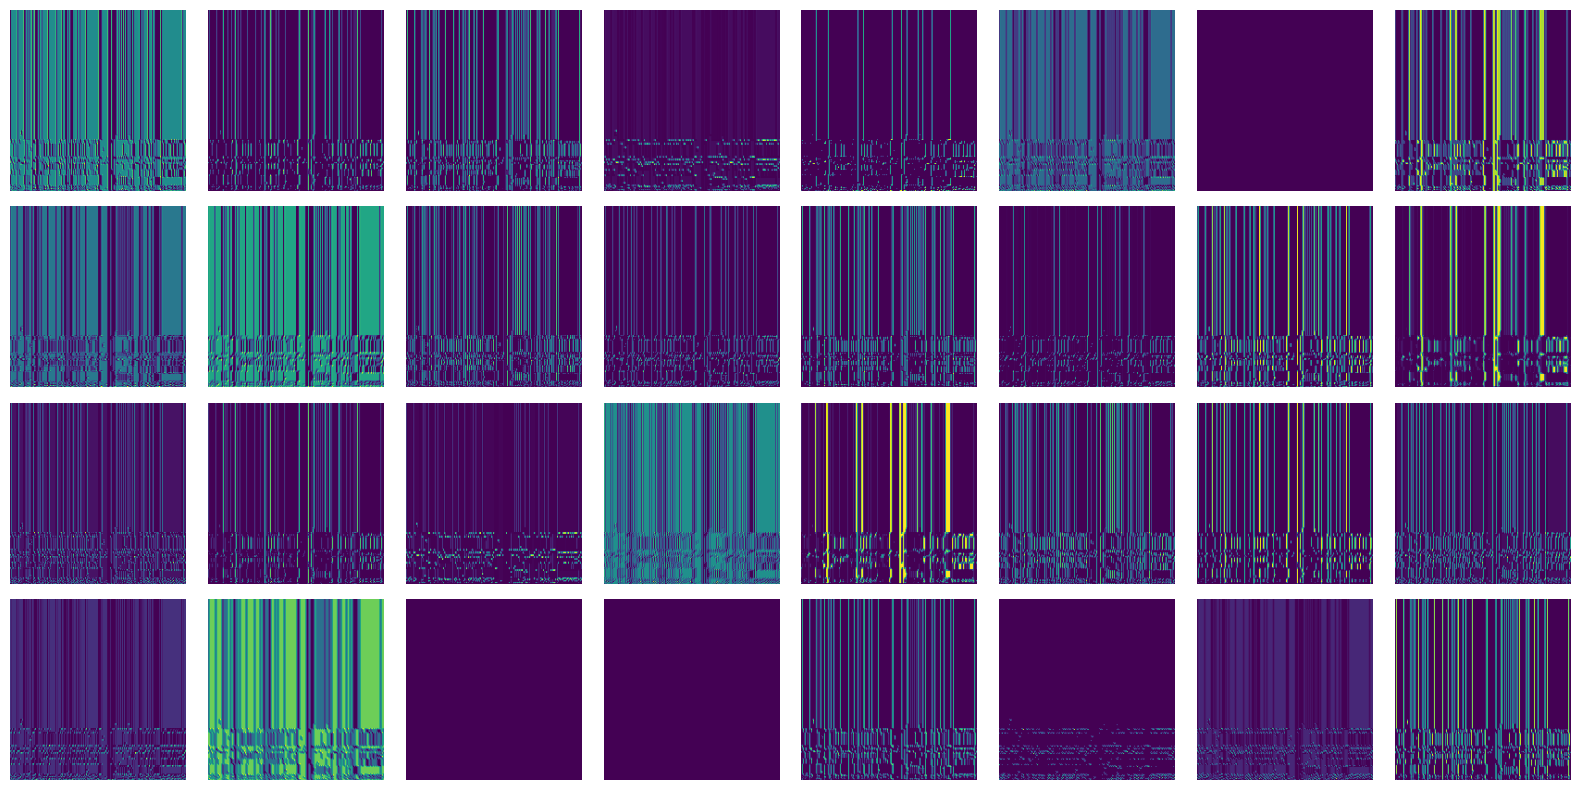

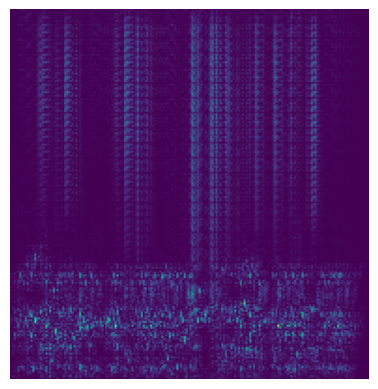

In [66]:
"""Calculate and plot the ROC Curve and AUC score for the model on the testing set."""

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
prob_predictions = model.predict(gene_sim_test.data).ravel()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(gene_sim_test.targets, prob_predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()





#


from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import math

# Correct the layer name based on your model.summary() output
layer_name = 'conv2d_15'  # Change to your specific conv layer name like 'conv2d_15'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

feature_maps = intermediate_layer_model.predict(gene_LCT.data[0:1])

# Visualization
n_features = feature_maps.shape[-1]
n_cols = 8
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 2, n_rows * 2))
for i, ax in enumerate(axes.flat):
    if i < n_features:
        ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
    ax.axis('off')
plt.tight_layout()
plt.show()





import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Make sure eager execution is enabled
tf.compat.v1.enable_eager_execution()

# Prepare a specific input example you are interested in (making sure it's a tf.Tensor)
input_example = tf.convert_to_tensor(gene_LCT.data[0:1], dtype=tf.float32)

class_idx = 0  # Assuming you're interested in the first class for binary classification

with tf.GradientTape() as tape:
    # Explicitly watch the input tensor
    tape.watch(input_example)

    # Obtain model prediction for the specific input example
    predictions = model(input_example)

    # Use the prediction to compute the loss you want gradients for
    loss = predictions[:, class_idx]

# Compute gradients of the loss with respect to the input
grads = tape.gradient(loss, input_example)

# Process gradients (saliency map)
saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)[0].numpy()
saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

# Visualize the saliency map
plt.imshow(saliency_map, cmap='viridis')
plt.axis('off')
plt.show()


For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

63/63 [==============================] - 29s 451ms/step


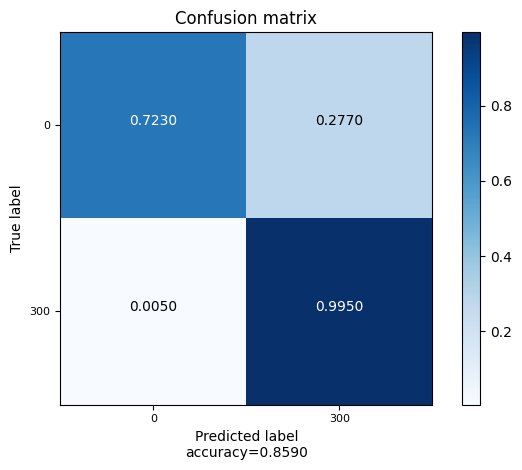

Precision: 0.7822327044025157
Recall: 0.995
F1 Score: 0.8758802816901409


In [67]:
# Predicting the classes using the model
net_LCT.predict(gene_sim_test, model)

# Plotting the confusion matrix
net_LCT.plot_cm(gene_sim_test.classes, text=True)

# Extracting the predictions made by the model
predicted_classes = net_LCT.values[1,:]

# Extracting the true class labels from the test data
true_classes = gene_sim_test.targets

# Importing the necessary functions from sklearn to calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculating the precision
precision = precision_score(true_classes, predicted_classes)

# Calculating the recall
recall = recall_score(true_classes, predicted_classes)

# Calculating the F1 score
f1 = f1_score(true_classes, predicted_classes)

# Printing out the precision, recall, and F1 score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


### 4. Deploy the trained network on your genomic data of interest

Finally we can use the trained network to predict natural selection on our locus of interest.
The output of this command will give us the class score (e.g. this can be interpreted as a posterior probability with uniform prior) of said locus under positive selection under the conditions we simulated.

In [73]:
print(model.predict(gene_LCT.data, batch_size=None)[0][0])

1/1 [==============================] - 0s 36ms/step
0.99781454
